# Advancded Lane Finding #

## The goals / steps of this project are the following:##
**1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.**<br>
**2. Apply a distortion correction to raw images.**<br>
**3. Use color transforms, gradients, etc., to create a thresholded binary image.**<br>
**4. Apply a perspective transform to rectify binary image ("birds-eye view").**<br>
**5. Detect lane pixels and fit to find the lane boundary.**<br>
**6. Determine the curvature of the lane and vehicle position with respect to center.**<br>
**7. Warp the detected lane boundaries back onto the original image.**<br>
**8. Output visual display of the lane boundaries and numerical estimation of lane and **
**   curvature and vehicle position.**
##### <font color=red>Most of the functions are from lessons on Udacity, with some modification</font> #####

**Import the libraries needed**

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

%matplotlib inline
%matplotlib qt

PREPARE = False

## Camera Calibration##

**The following code uses images in the the folder "camera_cal" to get the calibration parameters of the cameras.One of the original photo and its undistorted version is displayed below. The function also saves the calibration parameters to a file so there's no need to run it every time**<br>
**The function collects corner points from chessboards and use them to get the camera calibration parameters.The calibration parameters can then be used to undistort any image taken from the same camera. The reason why chessboard is used is because the wrapped function avaliable in opencv, it is easy to detect corners due to the distinct black and white of the squares.**

In [2]:
def prepare(folder = "camera_cal"):
    """
    This function prepares calibration parameters for future usage
    :param folder: folder that contains chessboard images, named calibration*.jpg
    :return:nothing
    """

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(folder + '/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

        # Test undistortion on an image
    img = mpimg.imread(folder +'/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('testUndistorted1.jpg', dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open(folder +"/wide_dist_pickle.p", "wb"))
    # dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)

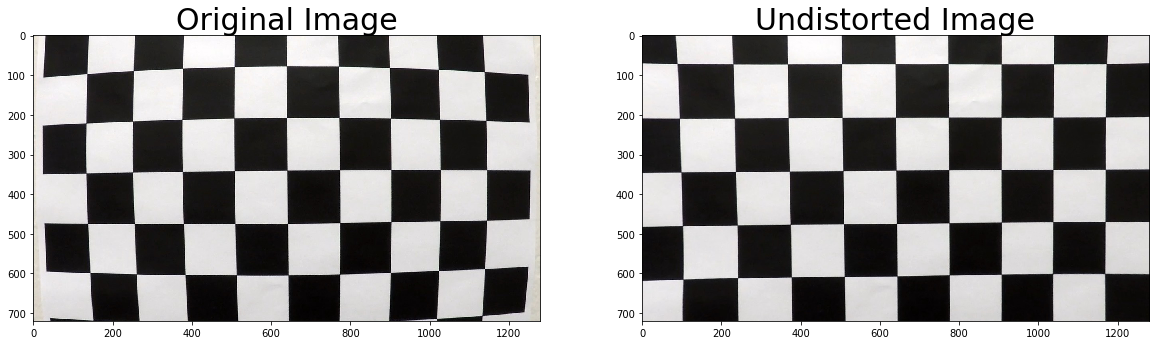

In [4]:
PREPARE = True
if PREPARE:
    prepare()

**Bewlow is a test on actual image taken from the car's camera, the effect is not too obvious due to the colorful backgrounds**

In [5]:
def undistort(image, mtx, dist):
    """
    undistorts a image
    :param image: An image matrix
    :param mtx: points for calibration
    :param dist: distination points for calibration
    :return: undistorted image
    """
    return cv2.undistort(image, mtx, dist, None, mtx)


def testUndistort():
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"] 
    img = mpimg.imread('test_images/test2.jpg')
    undistortedIm = undistort(img, mtx, dist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    cv2.imwrite('test_images/testUndistorted2.jpg',undistortedIm)
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undistortedIm)
    ax2.set_title('Undistorted Image', fontsize=30)


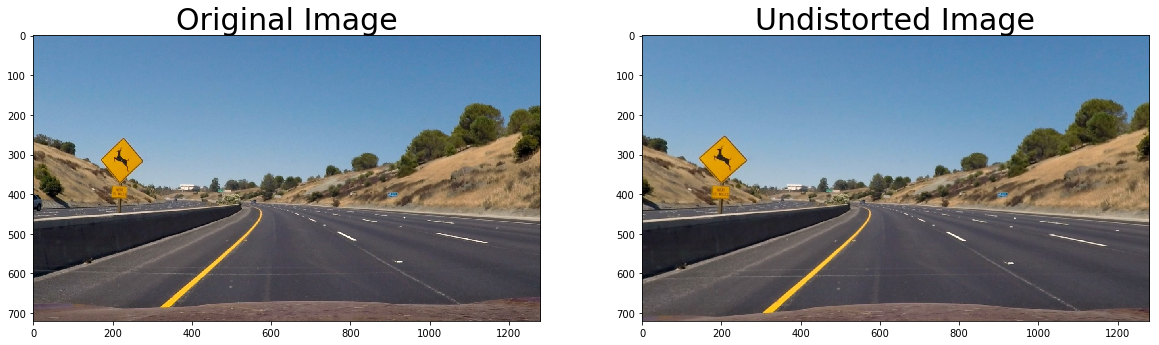

In [6]:
testUndistort()

## Thresholding##
**Below are functions used for threshholding,the convert2Binary is a wrapped up fuction for converting a color car video image to a binary image** 
**It first extracts the R channel and S channel from the image, which picks up the yellow lane very well. Then I applied color thresholding from the previous project on RGB channels with R=G=B > 200, which picks up the white lane well. It displays a good result.**

In [7]:
def getSpecificChannel(image, channel):
    """
    extracts a specific channel from a RGB image
    :param image: RGB image
    :param channel: should be one of R, G, B, H, S, V, L, case sensitive
    :return: The specified channel of the image
    """
    if (channel == 'R'):
        return image[:, :, 0]
    elif (channel == 'G'):
        return image[:, :, 1]
    elif (channel == 'B'):
        return image[:, :, 2]
    elif (channel == 'H'):
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:, :, 0]
    elif (channel == 'S'):
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:, :, 1]
    elif (channel == 'V'):
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:, :, 2]
    elif (channel == 'L'):
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:, :, 1]
    elif (channel == 'Y'):
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:, :, 0]
    elif (channel == 'U'):
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:, :, 1]
    elif (channel == 'YV'):
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:, :, 2]
    
def convert2Binary(img, mode  = 1):
    """
    converts a 3-channel image to a binary image
    :param img: color image
    :return: binary image that has been thresholded
    """
    if mode == 1:   
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        rChannel = getSpecificChannel(img, 'R')
        sChannel = getSpecificChannel(img, 'S')
        thresh = (80, 255)
        binary = np.zeros_like(sChannel)
        binary[(sChannel > thresh[0]) & (sChannel <= thresh[1])] = 1
        
        thresh2 = (80, 255)
        binary2 = np.zeros_like(rChannel)
        binary2[(rChannel > thresh2[0]) & (rChannel <= thresh2[1])] = 1
        
        red_threshold = 200
        green_threshold = 200
        blue_threshold = 200
        rgb_threshold = [red_threshold, green_threshold, blue_threshold]
        image = np.copy(img)
        color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(binary)
        #combined_binary[(gradx == 1) & (grady == 1) | (s_binary == 1)] = 1
        combined_binary[((binary == 1) & (binary2 == 1)) | ~color_thresholds] = 1
        return combined_binary

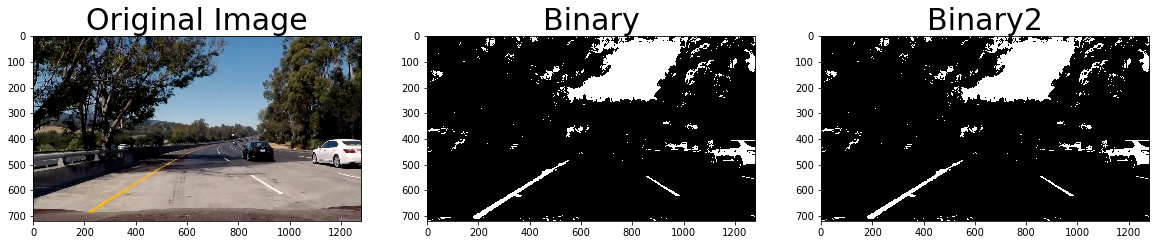

In [8]:
def testBinary():
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"] 
    img = mpimg.imread('test_images/test5.jpg')
    undistortedIm = undistort(img, mtx, dist)
    binary = convert2Binary(undistortedIm)
    binary2 = convert2Binary(undistortedIm, 1)
    #binary2 = cv2.erode(binary2, np.ones((3,3)))
    #binary2 = cv2.dilate(binary2, np.ones((3,3)))

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    #cv2.imwrite('test_images/testUndistorted2.jpg',undistortedIm)
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(binary, cmap='gray')
    ax2.set_title('Binary', fontsize=30)
    ax3.imshow(binary2, cmap='gray')
    ax3.set_title('Binary2', fontsize=30)
    
testBinary()

In [9]:
def perspectiveTransform(binary_image):
    """
    persform a perpective transform to a binary_image, returns a bird eye view perspective of the image
    :param binary_image: a binary image
    :return: bird eye view image, the inverse matrix of the transform
    """
    #img_size = binary_image.shape[::-1] # (width,height)
    h,w = binary_image.shape[:2]

    src = np.float32([(575,464),
                      (707,464), 
                      (258,682), 
                      (1049,682)])
    dst = np.float32([(450,0),
                      (w-450,0),
                      (450,h),
                      (w-450,h)])
    #src = np.float32([ [580,450], [160,h-10], [1150,h-10], [740,450]])
    #dst = np.float32([ [0,0], [0,h + 10], [w + 10,h + 10], [w + 10,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(binary_image, M, (binary_image.shape[1], binary_image.shape[0]),flags=cv2.INTER_NEAREST), invM

**The function above is used to transform a image and convert to a bird's eye view, below is a test function that shows the effect of the preprocessing and transforming**

In [10]:
def testFunctionSoFar(show=False):
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"] 
    img = mpimg.imread('test_images/test2.jpg')
    transformed = undistort(img, mtx, dist)
    binary = convert2Binary(transformed, 1)
    transformed, invM = perspectiveTransform(binary)
    
    
    if show:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Undistorted Image', fontsize=30)
        ax3.imshow(binary, cmap='gray')
        ax3.set_title('Binary Image', fontsize=30)
        ax2.imshow(transformed, cmap='gray')
        ax2.set_title('Bird Eye Image(Binary)', fontsize=30)
    return transformed, invM, img

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[  3.47368421e-01,  -7.38813387e-01,   4.18684211e+02],
        [  5.32907052e-15,  -4.86374491e-01,   4.64000000e+02],
        [  7.37257477e-18,  -1.15711476e-03,   1.00000000e+00]]),
 array([[[251, 240, 236],
         [217, 209, 207],
         [184, 182, 187],
         ..., 
         [ 26,  36,  46],
         [ 39,  43,  52],
         [ 46,  46,  54]],
 
        [[196, 199, 206],
         [146, 153, 163],
         [130, 142, 156],
         ..., 
         [ 47,  65,  87],
         [ 20,  33,  52],
         [ 32,  40,  59]],
 
        [[134, 155, 176],
         [132, 156, 180],
         [106, 136, 164],
         ..., 
         [ 86, 118, 156],
         [ 52,  78, 113],
         [ 12,  35,  69]],
 
        ..., 
        [[128, 113, 106],
         [ 94,  8

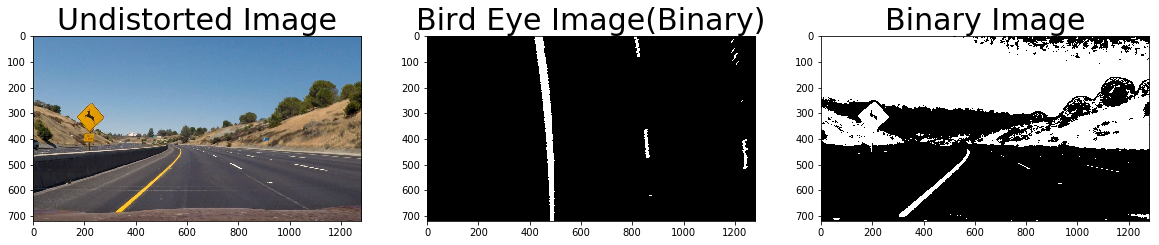

In [11]:
testFunctionSoFar(show = True)

## Lane line finding ##
**The below functions are used to identify the lane lines in the bird eye view image obtained above**<br>
**hist function counts the pixel value along the X-axis (the longer one), by doing this, the possible starting point of the lane can be identified (The x-coordinate that has the highest y signal). The sum area only includes the bottom half and the middle half of image, and this helps a lot when trying to get rid of noise and lanes, because sometimes other lanes have a higher pixel sum than the middle two we are interested in.**<br>
**findLanePixels identifies lane pixels using the sliding window method to continue searching for pixels along the y-axis and distribute them into left and right lanes**
**The fitPolynomial function fits a polynomial using the left and right lane points identified by findLanePixels function**

In [12]:
def hist(img, direction=0):
    """
    sums the pixel value along a certain axis of matrix
    :param img: image matrix
    :param direction: axis to be sumed along
    :return: numpy array containing the sums along the given direction
    """
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0] // 2:, :]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=direction)

    return histogram

def findBase(histogram):
    midpoint = np.int(histogram.shape[0] // 2)
    index = np.argsort(histogram[:midpoint])
    curMinDist = 10000
    leftBase = 0
    for ind in index:
        if histogram[ind] > 30:
            if abs(ind - midpoint) < curMinDist:
                leftBase = ind
                curMinDist = abs(ind - midpoint)
                
                
    index = np.argsort(histogram[midpoint:])
    curMinDist = 10000
    rightBase = 0
    for ind in index:
        if histogram[ind + midpoint] > 30:
             if ind < curMinDist:
                rightBase = ind + midpoint
                curMinDist = ind
    return leftBase, rightBase
def findLanePixels(binary_warped):
    """

    :param binary_warped: binary image that has been transformed to bird eye view
    :return: leftx, lefty, rightx, righty, out_img, midPointOfLane
    leftx: x coordinates of the left lane's pixel, lefty,rightx, righty are similar
    out_img: image with window area drawn
    midPointOfLane: the mid point x coordinate of the left and right lane
    """
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[histogram.shape[0] // 4:midpoint]) + histogram.shape[0] // 4
    rightx_base = np.argmax(histogram[midpoint:histogram.shape[0]*3 // 4]) + midpoint
    #leftx_base, rightx_base = findBase(histogram)
    midPointOfLane = (leftx_base + rightx_base) // 2
    #plt.figure()
    #plt.plot(histogram)
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img, midPointOfLane


def fitPolynomial(binary_warped, show=False):
    """
    fits polynomial to the lanes on a binary image
    :param binary_warped: bird eye view binary image
    :param show: whether or not to plot the fitted line
    :return: out_img, left_fitx, right_fitx, left_fit, right_fit, midPointOfLane
    out_img: image with line drawn if show is true
    left_fitx, right_fitx: x coordiantes of points for polynomial line
    left_fit, right_fit: parameters for the fitted polynomial
    """
    # Find our lane pixels first
    #plt.figure()
    #plt.imshow(binary_warped, cmap='gray')
    leftx, lefty, rightx, righty, out_img, midPointOfLane = findLanePixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if show:
        plt.figure()
        plt.imshow(binary_warped, cmap="gray")
        plt.figure()
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
    return out_img, [leftx, lefty], [rightx, righty], left_fit, right_fit, (midPointOfLane - binary_warped.shape[0])/2

**The following function measures the curvature of the two lane lines, which is an important data to self driving cars, so that they know how much they should turn**

In [13]:
def measureCurvature(left, right):
    """
    Calculates the curvature in meters.
    :param ploty: image
    :param left_fit: parameters for left lane fitted polynomial
    :param right_fit: parameters for right lane fitted polynomial
    :return: left and right curvature
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)
    left_fit_cr = np.polyfit(left[1]*ym_per_pix, left[0]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right[1]*ym_per_pix, right[0]*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    #t_fit_cr
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

**The drawLaneArea function will draw fill the gap between the two identified lane lines, and eventually transform the bird eye view image back to the original view**

In [14]:
def drawLaneArea(binary_warped, undistortedOrig, left_fit, right_fit, inverseMatrix):
    """
    draws the lane line area on the binary image, and transforms it back to the original view
    :param binary_warped: binary image
    :param undistortedOrig: undistorted color image
    :param left_fit: left fitted points(x coordinates)
    :param right_fit: right fitted points(x coordinates) 
    :param inverseMatrix: the matrix corresponding to the perspective transform from bird eye view to original view
    :return: original view image with lane line drawn and gap filled
    """
    ploty =  np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts[0]]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, inverseMatrix, (undistortedOrig.shape[1], undistortedOrig.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistortedOrig, 1, newwarp, 0.3, 0)
    return result

In [15]:
def testSoFar(showIm = False):
    transformed, invM, img = testFunctionSoFar(True)
    out_img, left, right ,left_fit, right_fit, deviation = fitPolynomial(transformed, show = showIm)
    plt.figure()
    plt.imshow(out_img)
    leftCurve, rightCurve = measureCurvature(left, right)
    result = drawLaneArea(transformed,img,  left_fit, right_fit, invM)
    xm_per_pix = 3.7/1280
    font = cv2.FONT_HERSHEY_SIMPLEX  
    result = cv2.putText(result, 'left curvature: '+str(leftCurve), (50, 50), font, 2, (255, 255, 255), 2)
    result = cv2.putText(result, 'right curvature: '+str(rightCurve), (50, 100), font, 2, (255, 255, 255), 2)
    result = cv2.putText(result, 'deviation from mid point: '+str((deviation*xm_per_pix)/2), (50, 150), font, 2, (255, 255, 255), 2)
    plt.figure()
    plt.imshow(result)

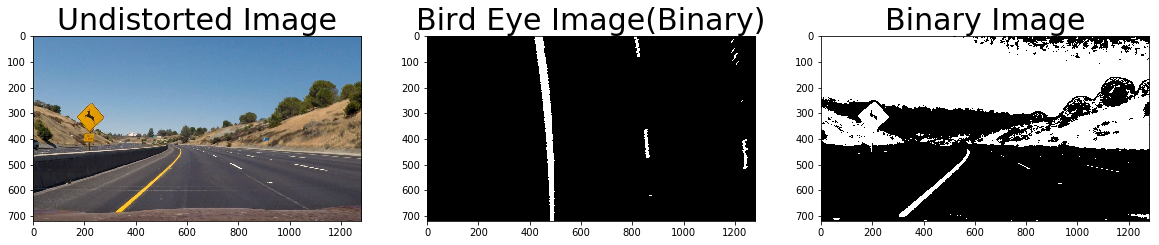

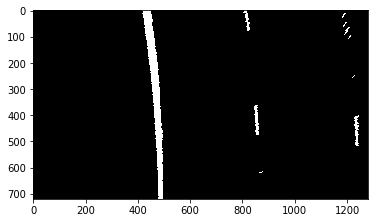

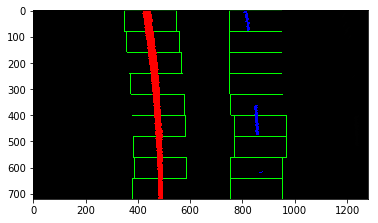

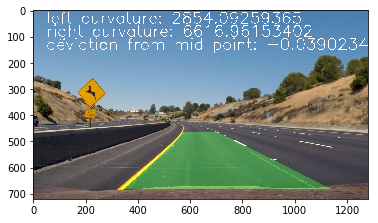

In [16]:
testSoFar(True)

## Complete pipeline function ##

In [21]:
def processImage(img, show = False):
    """
    Pipeline for processing functions, used for the video clip generation
    """
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"] 
    undistortedIm = undistort(img, mtx, dist)
    if show:
        plt.figure()
        plt.imshow(undistortedIm)
    transformed = convert2Binary(undistortedIm, 1)
    transformed, invM = perspectiveTransform(transformed)
    if show:
        plt.figure()
        plt.imshow(transformed, cmap='gray')
    out_img, left, right,left_fit, right_fit, deviation = fitPolynomial(transformed)
    if show:
        plt.figure()
        plt.imshow(out_img)
    leftCurve, rightCurve = measureCurvature(left, right)
    result = drawLaneArea(transformed,img,  left_fit, right_fit, invM)
    xm_per_pix = 3.7/1280
    font = cv2.FONT_HERSHEY_SIMPLEX  
    result = cv2.putText(result, 'left curvature: '+str(leftCurve) + 'meters', (50, 50), font, 1.5, (255, 255, 255), 2)
    result = cv2.putText(result, 'right curvature: '+str(rightCurve)+ 'meters', (50, 100), font, 1.5, (255, 255, 255), 2)
    result = cv2.putText(result, 'deviation from mid point: '+str((deviation*xm_per_pix)/2), (50, 150), font, 1.5, (255, 255, 255), 2)
    if show:
        plt.figure()
        plt.imshow(result)
    return result

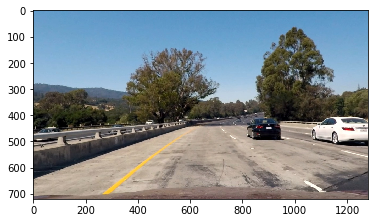

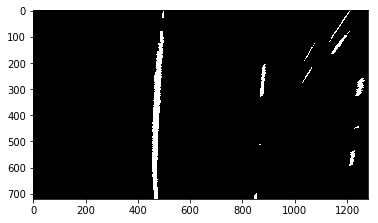

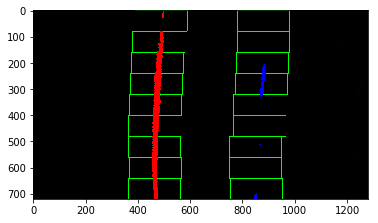

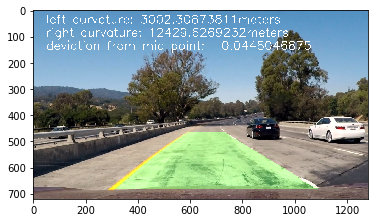

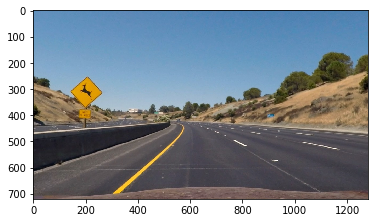

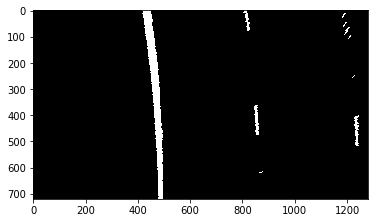

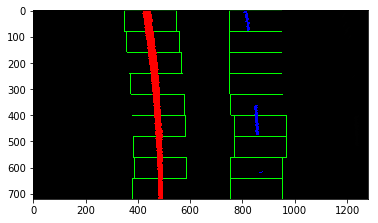

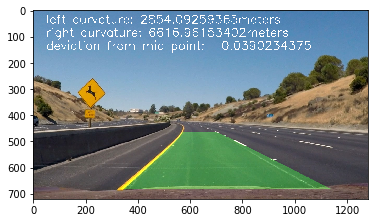

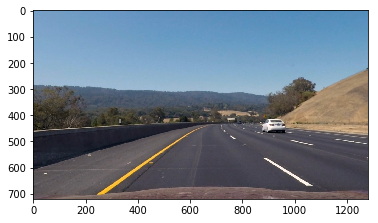

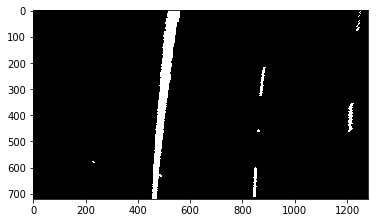

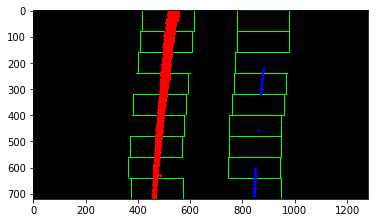

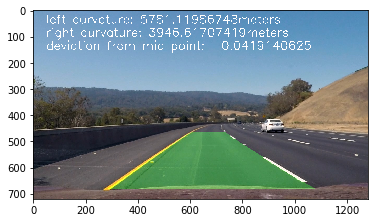

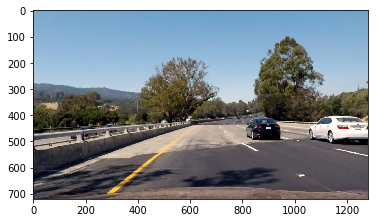

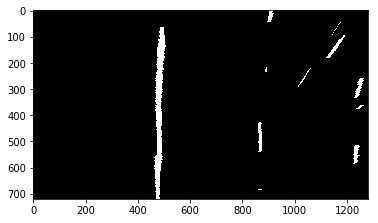

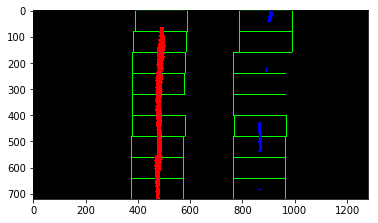

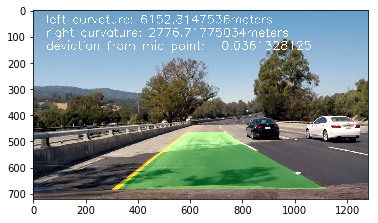

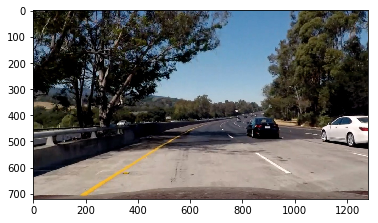

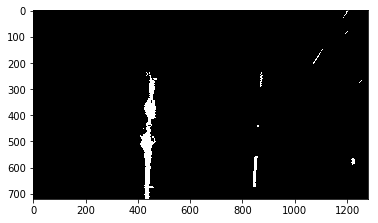

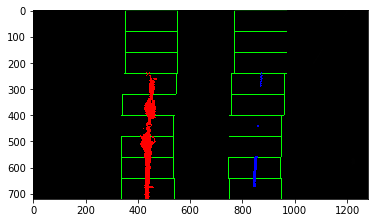

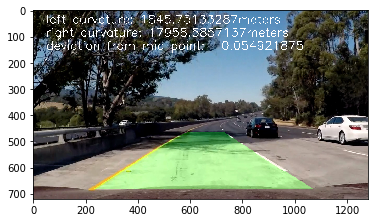

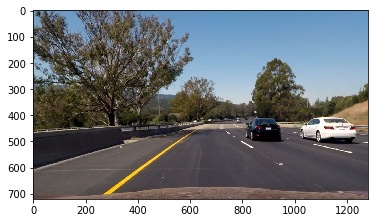

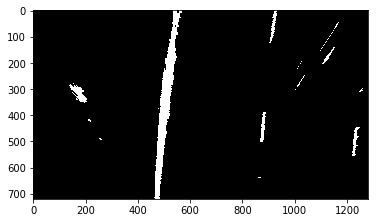

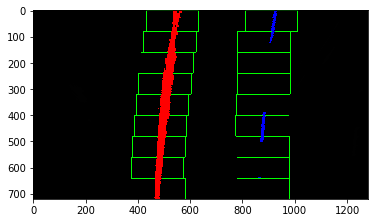

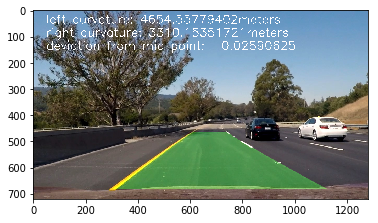

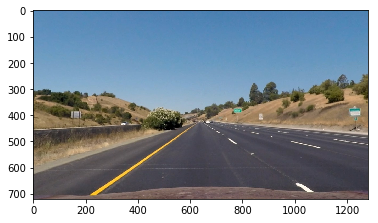

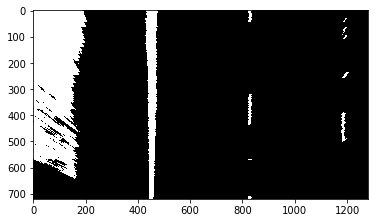

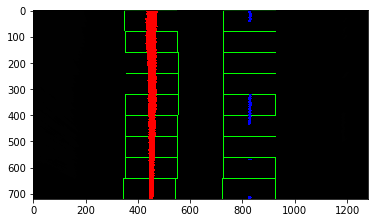

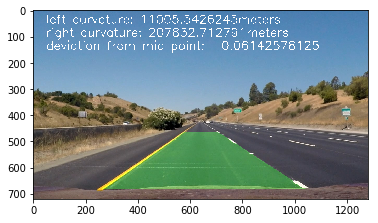

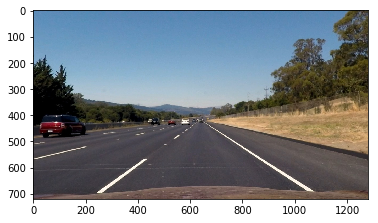

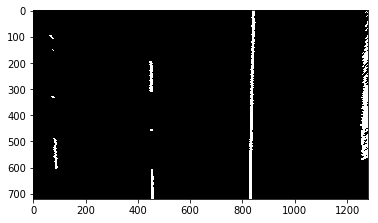

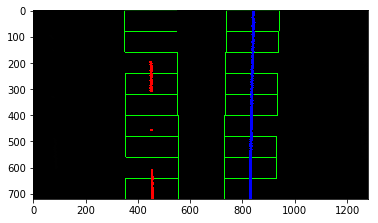

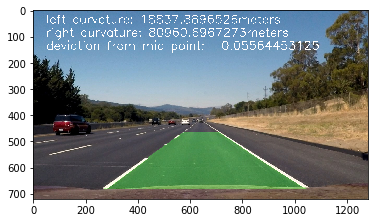

In [22]:
fileList = os.listdir('test_images')
allTest = ["test1.jpg","test2.jpg","test3.jpg","test4.jpg","test5.jpg","test6.jpg","straight_lines1.jpg","straight_lines2.jpg"]
for file in allTest:
    img = mpimg.imread('test_images/' + file)
    result = processImage(img, show = True)

## Make Video##

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
MAKE = True

**The make video cell is somehow working weirdly, as it doesn't complete even after the function is done, but the video can be made**

In [20]:
if MAKE:
    projectVideoOutput = "projectOutput.mp4"
    clip2 = VideoFileClip('project_video.mp4')
    yellow_clip = clip2.fl_image(processImage)
    %time yellow_clip.write_videofile(projectVideoOutput, audio=False)

[MoviePy] >>>> Building video projectOutput.mp4
[MoviePy] Writing video projectOutput.mp4


100%|█████████▉| 1260/1261 [04:50<00:00,  4.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: projectOutput.mp4 

CPU times: user 2min 39s, sys: 2.92 s, total: 2min 42s
Wall time: 4min 53s


## Final Video ##
**Or check<font color=red> projectOutput.mp4</font> in the same directory**

In [23]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(projectVideoOutput))

## Discussion ##
**The eventual output is generally satisfying, however it is not perfect. In many frames of the video, there is some gap between the green area and the left white lane line. A reason for this might be the right lane line is not continuos, so the fitting had a greater variation.<br>
The project introduces a lot of useful computer vision techniques and methods that are valuable to other projects, I have personally used the histogram method to improve some image cropping project.<br>
Further improvement to such task may involve machine learning. It is very important to develop a program that is able to identify lane lines robustly with respect to the background, the light change etc.**<br>
**A great way to debug this project is to extract the frames from the video and process all the frames. By this way, we can easily locate frames that our alogorithms are not able to detect correctly.**